In [9]:
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_embed, reg_nn_lmm
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

In [2]:
data = pd.read_csv(r"D:\Notes\Sem - 6\Thesis\Mixed Effect Model\Lit\datasets\InstEval\InstEval.csv")
data = data.iloc[:, 1:]
data = data.rename(columns={'s': 'students','d': 'instructors','dept': 'departments','y': 'ratings'})
data.head()

,students,instructors,studage,lectage,service,departments,ratings
0,1,1002,2,2,0,2,5
1,1,1050,2,1,1,6,2
2,1,1582,2,2,0,2,5
3,1,2050,2,2,1,3,3
4,2,115,2,1,0,5,2


In [3]:
data['students'] -= 1
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

print(data.shape)
data.head()

(73421, 7)


,students,instructors,studage,lectage,service,departments,ratings
0,0,524,2,2,0,1,5
1,0,559,2,1,1,5,2
2,0,831,2,2,0,1,5
3,0,1067,2,2,1,2,3
4,1,61,2,1,0,4,2


In [4]:
n_cat_students = max(data['students']) + 1
n_cat_instructors = max(data['instructors']) + 1
n_cat_departments = max(data['departments']) + 1

print("Number of students:", n_cat_students)
print("Number of instructors:", n_cat_instructors)
print("Number of departments:", n_cat_departments)

Number of students: 2972
Number of instructors: 1128
Number of departments: 14


In [5]:
data.rename(columns={'students': 'z0',
                     'departments': 'z2',
                    'instructors': 'z1'}, inplace=True)

In [6]:
mode = 'intercepts'
n_sig2bs = 3
n_sig2bs_spatial = 0
est_cors = []
n_neurons = [10, 3]
activation = 'relu'
dropout = []
spatial_embedded_neurons = []
n_cats = [n_cat_students, n_cat_instructors, n_cat_departments]
dist_matrix = None
q_spatial = None
x_cols = x_cols = ['studage', 'lectage', 'service']

In [7]:
from sklearn.model_selection import train_test_split

X, y = data.drop('ratings', axis=1), data['ratings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Epoch 1/200
222/222 [==============================] - 3s 10ms/step - loss: 396.7752 - val_loss: 356.8195
Epoch 2/200
222/222 [==============================] - 2s 10ms/step - loss: 357.8503 - val_loss: 346.9121
Epoch 3/200
222/222 [==============================] - 3s 12ms/step - loss: 353.4609 - val_loss: 345.1962
Epoch 4/200
222/222 [==============================] - 3s 13ms/step - loss: 351.5267 - val_loss: 343.5007
Epoch 5/200
222/222 [==============================] - 3s 15ms/step - loss: 349.7500 - val_loss: 341.9015
Epoch 6/200
222/222 [==============================] - 3s 13ms/step - loss: 347.9059 - val_loss: 340.2204
Epoch 7/200
222/222 [==============================] - 3s 15ms/step - loss: 345.9044 - val_loss: 338.2699
Epoch 8/200
222/222 [==============================] - 3s 15ms/step - loss: 343.5021 - val_loss: 335.6953
Epoch 9/200
222/222 [==============================] - 3s 15ms/step - loss: 340.4131 - val_loss: 332.7227
Epoch 10/200
222/222 [========================

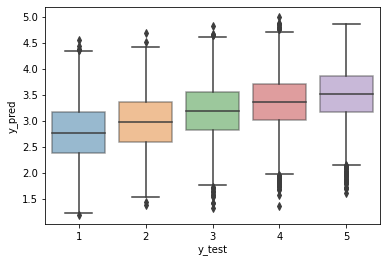

 finished lmm, mse: 1.45


In [10]:
def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=200, epochs=200, patience=5, reg_type='ohe', verbose=False):
    start = time.time()
    if reg_type == 'lmm':
        y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, q_spatial, x_cols, batch, epochs, patience,
                                                 n_neurons, dropout, activation,
                                                 mode=mode, n_sig2bs=n_sig2bs, n_sig2bs_spatial=n_sig2bs_spatial,
                                                 est_cors=est_cors, dist_matrix=dist_matrix,
                                                 spatial_embed_neurons=spatial_embedded_neurons, verbose=verbose, log_params=False)
    
    end = time.time()
    gc.collect()
    y_pred = np.clip(y_pred, 1, 5)
    mse = np.mean((y_pred - y_test)**2)
    sns.boxplot(x='y_test', y='y_pred', data=pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}), boxprops=dict(alpha=0.5))
    plt.show()
    return mse, sigmas, n_epochs, end - start, y_pred

mse_lmm, sigmas, n_epochs_lmm, time_lmm, y_pred = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', verbose=True)
print(' finished lmm, mse: %.2f' % (mse_lmm))

# ---------------------------------------------------------------